In [65]:
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from matplotlib.pylab import plt

import numpy as np
%matplotlib inline

In [66]:
def plot_model_line(x, y, x_in, y_out, title="", xlabel="", ylabel="", length=7, height=5):
    fig, ax = plt.subplots(figsize=(length,height))
    if (title != ""):
        ax.set_title(title)
    if (xlabel != ""):
        ax.set_xlabel(xlabel)
    if (ylabel != ""):
        ax.set_ylabel(ylabel)
    ax.plot(x, y, c='r', marker="s", label='Input')
    #ax.bar(x, y, label='Input')
    ax.plot(x_in, y_out, label='Predicted')
    plt.legend(loc='upper left');
    plt.show()
    
def month_to_month_ridership_trends(station_data, months, station):
    month_key='Month'
    x_label ="index"
    y_label="Avg_Weekday"
    formula = "Avg_Weekday~index"
    coefs = []
    for month in months: 
        sample = station_data[station_data[month_key] == month]
        lm = smf.ols(formula = formula, data = sample).fit()
        predicted_ys = lm.predict()
        coefs.append(lm.params[x_label])

    plt.figure(figsize=(10,5))
    plt.title("{}: Month to Month Trends".format(station))
    plt.xticks(months)
    plt.xlabel(month_key)
    plt.axvline(x=9, color='r', linestyle='--')
    plt.axhline(y=0, color='k')
    plt.plot(months, coefs)
    
def interyear_ridership_trends(ridership_data, years, station):    
    year_key = "Year"
    formula = "Avg_Weekday~index"
    x_label ="index"
    y_label="Avg_Weekday"
    plt.figure(figsize=(20,5))
    height = 5
    length = 10
    for year in years:
        sample = ridership_data[ridership_data[year_key] == year]
        lm = smf.ols(formula = formula, data = sample).fit()
        predicted_ys = lm.predict()

        fig, ax = plt.subplots(figsize=(length,height))  
        ax.set_title("{}: Yearly Trends in Ridership {}".format(station, year))
        ax.plot(sample['yyyymm'], sample[y_label], c='r', marker="s", label=y_label)
        ax.plot(sample['yyyymm'], predicted_ys, label='Trend')
        plt.legend(loc='upper left');
        plt.show()

def overall_trend(ridership_data, station): 
    formula = "Avg_Weekday~index"
    x_label = "yyyymm"
    y_label = "Avg_Weekday"

    lm = smf.ols(formula = formula, data = ridership_data).fit()
    predicted_ys = lm.predict()
    plot_model_line(ridership_data[x_label], ridership_data[y_label], 
                    ridership_data[x_label], predicted_ys, 
                    length=20, height=5, title="{}: PATH Ridership Trend".format(station))
    print("{}: Ridership Growth Trend in [201701 -> 201809]: {}".format(station, lm.params['index']))


In [67]:
path_ridership = pd.read_csv("../data/path_ridership_data/path_ridership.csv", thousands=',')
path_ridership.head()

,Station,Year,Month,Month_Totals,Avg_Weekday,Avg_Saturday,Avg_Sunday,Avg_Holiday
0,Journal Square,2019,9,724999,29541,16058,11932,10293
1,Grove Street,2019,9,566317,23338,12448,8701,6259
2,Exchange Place,2019,9,414785,18658,4948,3741,3123
3,Pavonia/ Newport,2019,9,474542,20037,8940,6552,5276
4,Journal Square,2019,8,717286,27074,15231,11373,0


In [68]:
stations = path_ridership.Station.unique()
months = path_ridership.Month.unique()
years = path_ridership.Year.unique()
stations.sort(), months.sort(), years.sort()

print(len(stations), len(months), len(years))

4 12 3


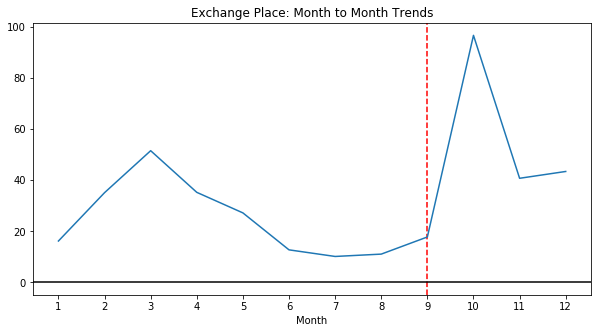

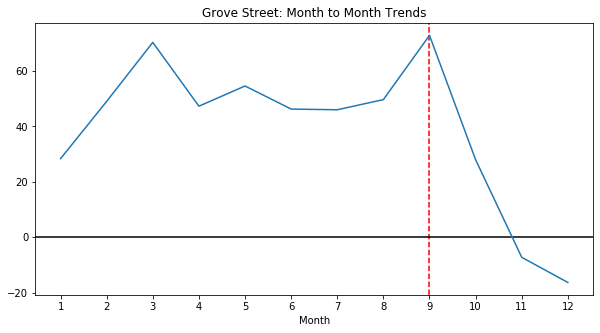

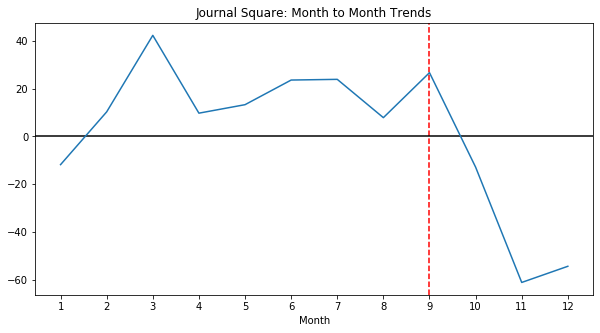

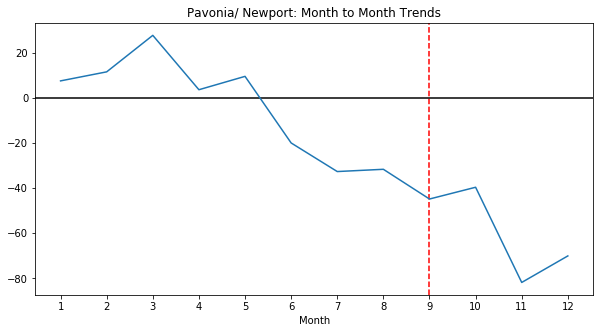

In [69]:
for station in stations:
    
    sample_gs = path_ridership[(path_ridership['Station'] == station) ].copy()
    sample_gs = sample_gs.sort_values(['Year', 'Month'], ascending=[True, True])

    sample_gs['yyyymm'] = sample_gs['Year'].apply(str) + sample_gs['Month'].apply(lambda x: str(x).zfill(2))
    sample_gs.reset_index(level=0, inplace=True)
    sample_gs['index'] = sample_gs.index

    month_to_month_ridership_trends(sample_gs, months, station)
